In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from metrics import MAE, MSE, RMSE, CORR
from ResNetBlock import ResNetLSTMModel  # Import the model
from physics_driven_block import Physics_driven_block
from torch.utils.tensorboard import SummaryWriter


In [17]:
# Load .mat file
mat_file_path = 'DAB.mat'  # Replace with your DAB converter file path
data = sio.loadmat(mat_file_path)

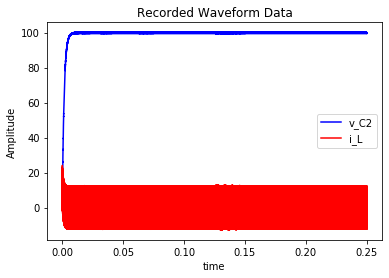

In [18]:
# Calling numerical methods - Runge-Kutta method
record_t, record_v_C2, record_i_L = Physics_driven_block(100, 15, 0.2212, 0.2212, 0.3957)

In [19]:
# Extract data
x1 = torch.tensor(data['real_i_L_idx'], dtype=torch.float32)
x2 = torch.tensor(data['real_v_C2_idx'], dtype=torch.float32)

In [20]:
# Construct the physical drive module time period corresponding to the measured data
idx = (record_t >= 0.01) & (record_t <= 0.015)
record_t_idx = record_t[idx]
record_v_C2_idx = record_v_C2[idx]
record_i_L_idx = record_i_L[idx]
# Extract data
y1 = torch.tensor(record_i_L_idx, dtype=torch.float32).unsqueeze(1)  # Adjust shape
y2 = torch.tensor(record_v_C2_idx, dtype=torch.float32).unsqueeze(1)  # Adjust shape
t = torch.tensor(data['t_idx'], dtype=torch.float32)

# Data normalization
x1_mean, x1_std = x1.mean(), x1.std()
x2_mean, x2_std = x2.mean(), x2.std()
y1_mean, y1_std = y1.mean(), y1.std()
y2_mean, y2_std = y2.mean(), y2.std()

x1 = (x1 - x1_mean) / x1_std
x2 = (x2 - x2_mean) / x2_std
y1 = (y1 - y1_mean) / y1_std
y2 = (y2 - y2_mean) / y2_std

# Data dimensions
num_time_steps = x1.size(0)
history_size = 7  # 窗口大小
batch_size = 32

# Prepare input data and target data
X1_input = []
X2_input = []
Y1_input = []
Y2_input = []
targets = []
time_indices = []

for i in range(num_time_steps - history_size):
    X1_input.append(x1[i:i + history_size])
    X2_input.append(x2[i:i + history_size])
    Y1_input.append(y1[i + history_size])
    Y2_input.append(y2[i + history_size])
    targets.append(torch.cat((x1[i + history_size], x2[i + history_size]), dim=0))
    time_indices.append(t[i + history_size])

X1_input = torch.stack(X1_input)
X2_input = torch.stack(X2_input)
Y1_input = torch.stack(Y1_input)
Y2_input = torch.stack(Y2_input)
targets = torch.stack(targets)
time_indices = torch.stack(time_indices)

# Create a dataset
dataset = TensorDataset(X1_input, X2_input, Y1_input, Y2_input, targets, time_indices)

# Divide the dataset in a ratio of 7:2:1
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Check dataset size
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

# Create data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# denormalization function
def inverse_transform(tensor, mean, std):
    return tensor * std + mean

# hyperparameters
input_size = 1
resnet_channels = 128
lstm_hidden_size = 256
output_size = 2
learning_rate = 0.005
num_epochs = 50


Training set size: 555
Validation set size: 158
Test set size: 80


In [21]:
# Initialize model, loss function and optimizer
model = ResNetLSTMModel(input_size, resnet_channels, lstm_hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# establish TensorBoard SummaryWriter
writer = SummaryWriter('runs/new_resnet_lstm_model')

# Example Input Data
x1_example = X1_input[0:1].permute(0, 2, 1)  # Adjust the input shape to(batch_size, 1, history_size)
x2_example = X2_input[0:1].permute(0, 2, 1)
y1_example = Y1_input[0:1]
y2_example = Y2_input[0:1]

# Record model structure to TensorBoard
writer.add_graph(model, (x1_example, x2_example, y1_example, y2_example))
#writer.close()

print("Model graph saved to runs/new_resnet_lstm_model. Use `tensorboard --logdir=runs` to visualize it.")


Model graph saved to runs/new_resnet_lstm_model. Use `tensorboard --logdir=runs` to visualize it.


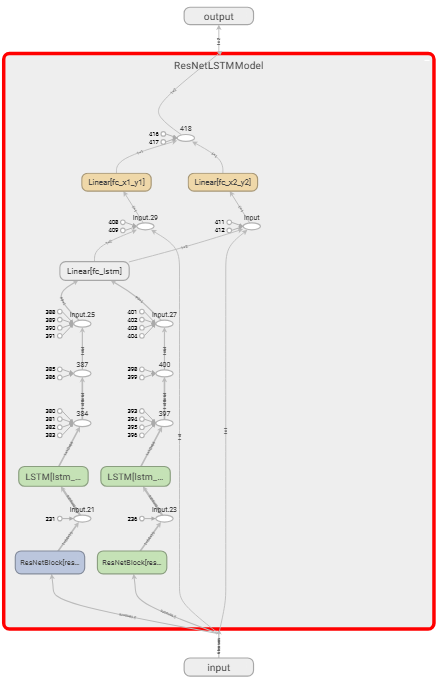

In [22]:
# Record training and validation losses
train_losses = []
val_losses = []
train_mae = []
val_mae = []
train_mse = []
val_mse = []
train_rmse = []
val_rmse = []
train_corr = []
val_corr = []

# Training model
best_val_loss = float('inf')
best_model_path = 'best_model.pth'
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    train_predictions = []
    train_targets = []

    for x1_batch, x2_batch, y1_batch, y2_batch, target_batch, _ in train_loader:
        x1_batch = x1_batch.permute(0, 2, 1)  # Adjust the input shape to (batch_size, 1, history_size)
        x2_batch = x2_batch.permute(0, 2, 1)

        optimizer.zero_grad()
        output = model(x1_batch, x2_batch, y1_batch, y2_batch)
        loss = criterion(output, target_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_predictions.append(output.detach().cpu().numpy())
        train_targets.append(target_batch.detach().cpu().numpy())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predictions = np.concatenate(train_predictions)
    train_targets = np.concatenate(train_targets)

    train_mae.append(MAE(train_predictions, train_targets))
    train_mse.append(MSE(train_predictions, train_targets))
    train_rmse.append(RMSE(train_predictions, train_targets))
    train_corr.append(CORR(train_predictions, train_targets))

    # Validate model
    model.eval()
    val_loss = 0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for x1_batch, x2_batch, y1_batch, y2_batch, target_batch, _ in val_loader:
            x1_batch = x1_batch.permute(0, 2, 1)
            x2_batch = x2_batch.permute(0, 2, 1)
            predictions = model(x1_batch, x2_batch, y1_batch, y2_batch)
            val_loss += criterion(predictions, target_batch).item()
            val_predictions.append(predictions.cpu().numpy())
            val_targets.append(target_batch.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predictions = np.concatenate(val_predictions)
    val_targets = np.concatenate(val_targets)

    val_mae.append(MAE(val_predictions, val_targets))
    val_mse.append(MSE(val_predictions, val_targets))
    val_rmse.append(RMSE(val_predictions, val_targets))
    val_corr.append(CORR(val_predictions, val_targets))

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Save the model with the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with validation loss: {best_val_loss:.4f}')
    model.train()


Epoch [1/50], Train Loss: 0.1759, Val Loss: 0.0261
Saved best model with validation loss: 0.0261
Epoch [2/50], Train Loss: 0.0133, Val Loss: 0.0025
Saved best model with validation loss: 0.0025
Epoch [3/50], Train Loss: 0.0018, Val Loss: 0.0003
Saved best model with validation loss: 0.0003
Epoch [4/50], Train Loss: 0.0010, Val Loss: 0.0006
Epoch [5/50], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [6/50], Train Loss: 0.0006, Val Loss: 0.0001
Saved best model with validation loss: 0.0001
Epoch [7/50], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [8/50], Train Loss: 0.0003, Val Loss: 0.0001
Saved best model with validation loss: 0.0001
Epoch [9/50], Train Loss: 0.0002, Val Loss: 0.0000
Saved best model with validation loss: 0.0000
Epoch [10/50], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [11/50], Train Loss: 0.0003, Val Loss: 0.0002
Epoch [12/50], Train Loss: 0.0002, Val Loss: 0.0001
Epoch [13/50], Train Loss: 0.0001, Val Loss: 0.0001
Epoch [14/50], Train Loss: 0.0001, Val Loss: 0.0001
Epoch

In [23]:
# test model
model.load_state_dict(torch.load(best_model_path))
model.eval()
test_predictions = []
test_targets = []
test_time = []

with torch.no_grad():
    for x1_batch, x2_batch, y1_batch, y2_batch, target_batch, time_batch in test_loader:
        x1_batch = x1_batch.permute(0, 2, 1)
        x2_batch = x2_batch.permute(0, 2, 1)
        predictions = model(x1_batch, x2_batch, y1_batch, y2_batch)
        test_predictions.append(predictions)
        test_targets.append(target_batch)
        test_time.append(time_batch)

    test_predictions = torch.cat(test_predictions).cpu().numpy()
    test_targets = torch.cat(test_targets).cpu().numpy()
    test_time = torch.cat(test_time).cpu().numpy()

    # inverse normalization
    test_predictions[:, 0] = inverse_transform(test_predictions[:, 0], x1_mean.item(), x1_std.item())
    test_predictions[:, 1] = inverse_transform(test_predictions[:, 1], x2_mean.item(), x2_std.item())
    test_targets[:, 0] = inverse_transform(test_targets[:, 0], x1_mean.item(), x1_std.item())
    test_targets[:, 1] = inverse_transform(test_targets[:, 1], x2_mean.item(), x2_std.item())

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(test_targets))
    print(f'Test Loss: {test_loss.item():.4f}')

    # Calculate evaluation metrics
    mae = MAE(test_predictions, test_targets)
    mse = MSE(test_predictions, test_targets)
    rmse = RMSE(test_predictions, test_targets)
    corr = CORR(test_predictions, test_targets)

    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'CORR: {corr:.4f}')


Test Loss: 0.0006
MAE: 0.0150
MSE: 0.0006
RMSE: 0.0236
CORR: 7.1873


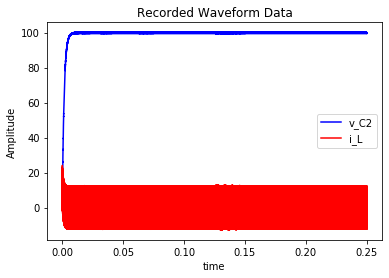

New Test Loss: 0.0007
New MAE: 0.0161
New MSE: 0.0007
New RMSE: 0.0269
New CORR: 6.8041


In [24]:
# Load new test data set
test_mat_file_path = 'DAB_test.mat'  # Replace with your .mat file path
test_data = sio.loadmat(test_mat_file_path)

# Extract test data
test_x1 = torch.tensor(test_data['real_i_L_idx'], dtype=torch.float32)
test_x2 = torch.tensor(test_data['real_v_C2_idx'], dtype=torch.float32)
#test_y1 = torch.tensor(test_data['RK_i_L_idx'], dtype=torch.float32)
#test_y2 = torch.tensor(test_data['RK_v_C2_idx'], dtype=torch.float32)

# Calling numerical methods - Runge-Kutta method
record_t, record_v_C2, record_i_L = Physics_driven_block(100, 9, 0.115, 0.115, 0.32)
# Build a test data set and select the time period of the measured values
idx = (record_t >= 0.0095) & (record_t <= 0.01)
record_t_idx = record_t[idx]
record_v_C2_idx = record_v_C2[idx]
record_i_L_idx = record_i_L[idx]

# Extract data
test_y1 = torch.tensor(record_i_L_idx, dtype=torch.float32).unsqueeze(1)  # 调整形状为 (800, 1)
test_y2 = torch.tensor(record_v_C2_idx, dtype=torch.float32).unsqueeze(1)  # 调整形状为 (800, 1)

test_t = torch.tensor(test_data['t_idx'], dtype=torch.float32)

# Data normalization
test_x1 = (test_x1 - x1_mean) / x1_std
test_x2 = (test_x2 - x2_mean) / x2_std
test_y1 = (test_y1 - y1_mean) / y1_std
test_y2 = (test_y2 - y2_mean) / y2_std

# Prepare input data and target data
test_X1_input = []
test_X2_input = []
test_Y1_input = []
test_Y2_input = []
test_targets = []
test_time_indices = []

for i in range(test_x1.size(0) - history_size):
    test_X1_input.append(test_x1[i:i + history_size])
    test_X2_input.append(test_x2[i:i + history_size])
    test_Y1_input.append(test_y1[i + history_size])
    test_Y2_input.append(test_y2[i + history_size])
    test_targets.append(torch.cat((test_x1[i + history_size], test_x2[i + history_size]), dim=0))
    test_time_indices.append(test_t[i + history_size])

test_X1_input = torch.stack(test_X1_input)
test_X2_input = torch.stack(test_X2_input)
test_Y1_input = torch.stack(test_Y1_input)
test_Y2_input = torch.stack(test_Y2_input)
test_targets = torch.stack(test_targets)
test_time_indices = torch.stack(test_time_indices)

# #Create test data set
test_dataset_new = TensorDataset(test_X1_input, test_X2_input, test_Y1_input, test_Y2_input, test_targets, test_time_indices)
test_loader_new = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

# #Test new test data set
new_test_predictions = []
new_test_targets = []
new_test_time = []

with torch.no_grad():
    for x1_batch, x2_batch, y1_batch, y2_batch, target_batch, time_batch in test_loader_new:
        x1_batch = x1_batch.permute(0, 2, 1)
        x2_batch = x2_batch.permute(0, 2, 1)
        predictions = model(x1_batch, x2_batch, y1_batch, y2_batch)
        new_test_predictions.append(predictions)
        new_test_targets.append(target_batch)
        new_test_time.append(time_batch)

    new_test_predictions = torch.cat(new_test_predictions).cpu().numpy()
    new_test_targets = torch.cat(new_test_targets).cpu().numpy()
    new_test_time = torch.cat(new_test_time).cpu().numpy()

    # inverse normalization
    new_test_predictions[:, 0] = inverse_transform(new_test_predictions[:, 0], x1_mean.item(), x1_std.item())
    new_test_predictions[:, 1] = inverse_transform(new_test_predictions[:, 1], x2_mean.item(), x2_std.item())
    new_test_targets[:, 0] = inverse_transform(new_test_targets[:, 0], x1_mean.item(), x1_std.item())
    new_test_targets[:, 1] = inverse_transform(new_test_targets[:, 1], x2_mean.item(), x2_std.item())

    new_test_loss = criterion(torch.tensor(new_test_predictions), torch.tensor(new_test_targets))
    print(f'New Test Loss: {new_test_loss.item():.4f}')

    # Calculate evaluation metrics
    new_mae = MAE(new_test_predictions, new_test_targets)
    new_mse = MSE(new_test_predictions, new_test_targets)
    new_rmse = RMSE(new_test_predictions, new_test_targets)
    new_corr = CORR(new_test_predictions, new_test_targets)

    print(f'New MAE: {new_mae:.4f}')
    print(f'New MSE: {new_mse:.4f}')
    print(f'New RMSE: {new_rmse:.4f}')
    print(f'New CORR: {new_corr:.4f}')



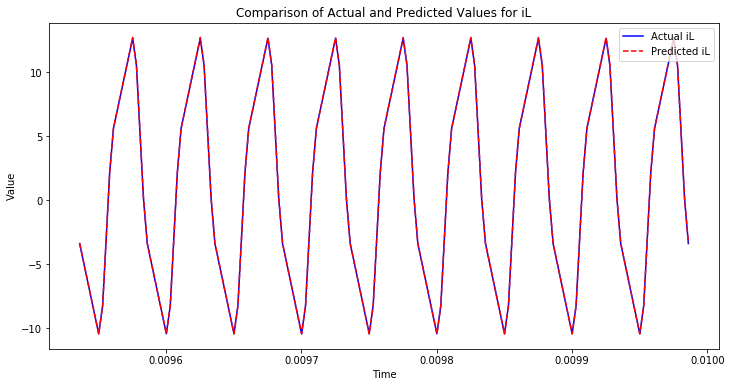

In [25]:
# Plot the predicted and actual values of x1
plt.figure(figsize=(12, 6))
plt.plot(new_test_time, new_test_targets[:, 0], label='Actual iL', color='blue')
plt.plot(new_test_time, new_test_predictions[:, 0], label='Predicted iL', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of Actual and Predicted Values for iL')
plt.show()

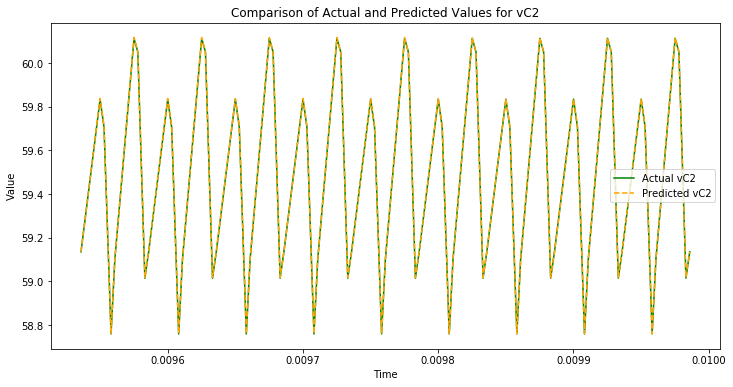

In [26]:
# Plot the predicted and actual values of x2
plt.figure(figsize=(12, 6))
plt.plot(new_test_time, new_test_targets[:, 1], label='Actual vC2', color='green')
plt.plot(new_test_time, new_test_predictions[:, 1], label='Predicted vC2', color='orange', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Comparison of Actual and Predicted Values for vC2')
plt.show()

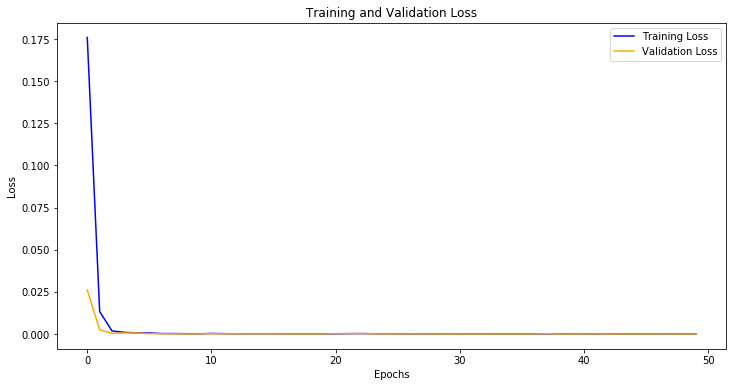

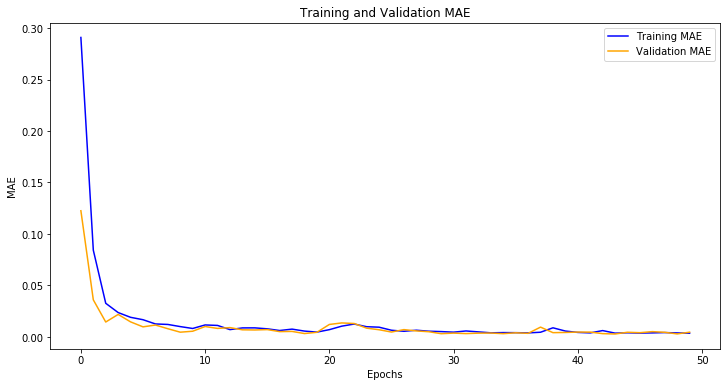

In [27]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_losses, label='Training Loss', color='blue')
plt.plot(range(num_epochs), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation MAE plots
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_mae, label='Training MAE', color='blue')
plt.plot(range(num_epochs), val_mae, label='Validation MAE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.show()



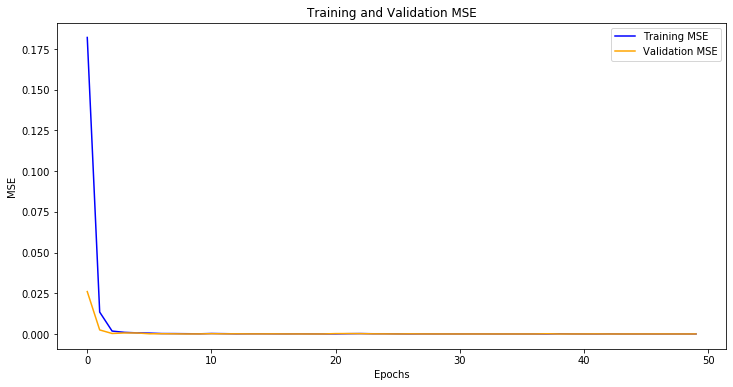

In [28]:
# Plot training and validation MSE plots
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_mse, label='Training MSE', color='blue')
plt.plot(range(num_epochs), val_mse, label='Validation MSE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Validation MSE')
plt.show()



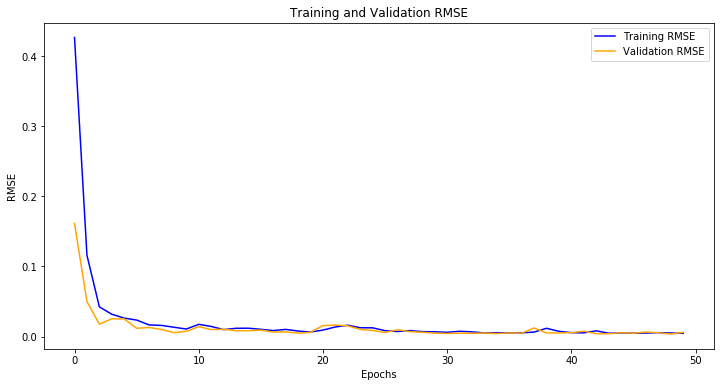

In [29]:
# Plot training and validation RMSE plots
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_rmse, label='Training RMSE', color='blue')
plt.plot(range(num_epochs), val_rmse, label='Validation RMSE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training and Validation RMSE')
plt.show()
